In [201]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pylab as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from statsmodels.tsa.arima_model import ARIMA

---

# Contents

1. **Load and prep the data**
2. **Visualise features**
3. **Looking at trends and seasonality**
    - 3a. CurrentSpeed
    - 3b. AirTemp 
    - 3c. CurrentDir
4. **ARIMA modelling**
    - 4a. CurrentSpeed modelling
    - 4b. AirTemp modelling
    - 4c. CurentDir modelling
5. **Using our forecasted predictions in our classification model**

This notebook is 3 ARIMA univariate analyses for the 3 most important weather features found in our classification model. I did not go forward with multivariate analysis due to the nature of the features and their lack of cointegration. I also attempted some GARCH models but ARIMA looked to perform the best in regards to their AIC, RMSE and forecasts.

---

## 1. Load and prep data 

In [2]:
df = pd.read_csv('data/all_data.csv', index_col=0)

Data is recorded by the second, relatively evenly spaced and forced into chronoligical order.

In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [4]:
df.set_index('DateTime', inplace = True)

In [5]:
df = df.sort_index()

Lets start by subsetting our top 3 most important weather features in our classification model.

In [6]:
df = df[['CurrentSpeed', 'AirTemp', 'CurrentDir', 'Tacking']]

---

## 2. Visualise features

We want to focus on the first indicator of change that alerts you to the possibility of tacking

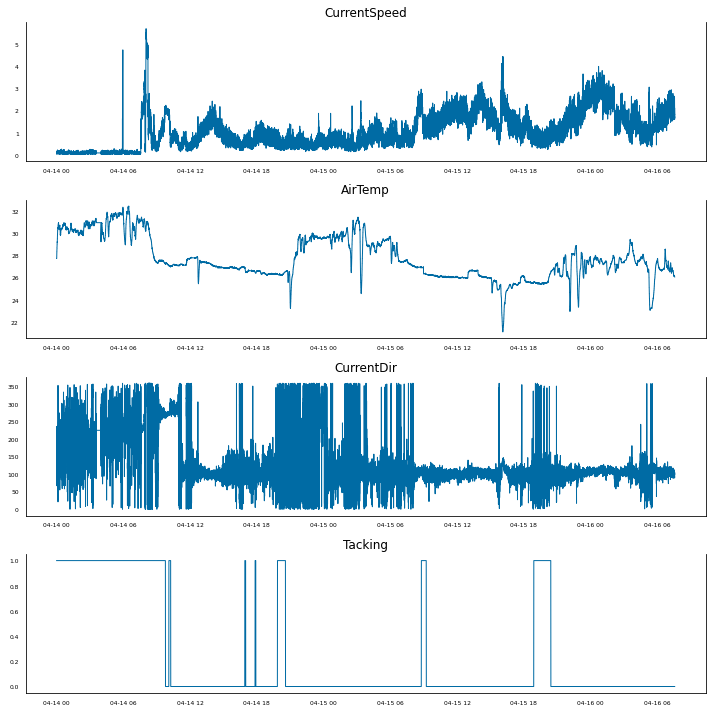

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=1)
for i, ax in enumerate(axes.flatten()):
    plt.rcParams["figure.figsize"] = (10,10)
    plt.style.use('tableau-colorblind10')
    data = df[df.columns[i]]
    ax.plot(data, linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
fig.tight_layout()

It's difficult to see if there is much trend or seasonality. However, from first glance it looks like just CurrentSpeed and AirTemp has some sort of trend.

---

In [7]:
#plots to check for evidence of trend or seasonality.

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [8]:
# Function that uses kpss test to check how many differences is needed in order to make the data stationary
def check_differences(cols, t):
    for col in cols:
        if col !='Tacking':
            print(ndiffs(df[col], test=t))

---

## 3. Looking at trends and seasonality

### 3a. CurrentSpeed

/Users/ella.franks/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


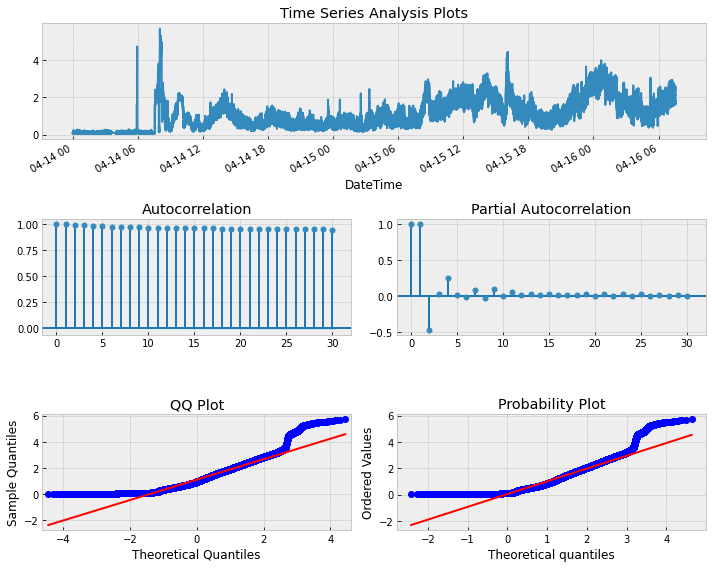

In [25]:
tsplot(df['CurrentSpeed'], lags=30)

From our plots, there seems to be no seasonality. However, there does seem to be a trend (seen when plotting less data). The TS is not stationary and thus before using this model to make predictions we would have to account for and remove the obvious autocorrelation present in the series. Firstly, we can resample the data by 30 second intervals and then take the mean differences of the data. 

However, it is a consideration in trying to find the balance between reducing autocorrelation and loosing granularity in the time intervals.

/Users/ella.franks/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


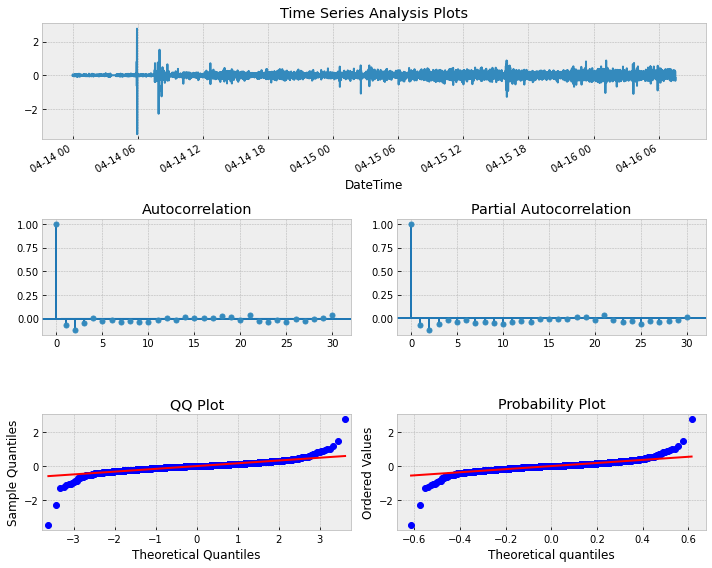

In [27]:
tsplot(df['CurrentSpeed'].resample('30S').mean().diff().dropna(), lags=30)

This looks a lot better. However, still some outliers (sticking out). This means there are shocks that model does not capture.

In order to estimate the number of differences required to make a given time series stationary. Will select the maximum value of d for which the time series is judged stationary by the statistical test. The default here is using the KPSS test.

In [21]:
check_differences(df, 'kpss') #thus use differencing (d) of 1 for all features

1
1
1


--- 

### 3b. AirTemp

/Users/ella.franks/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


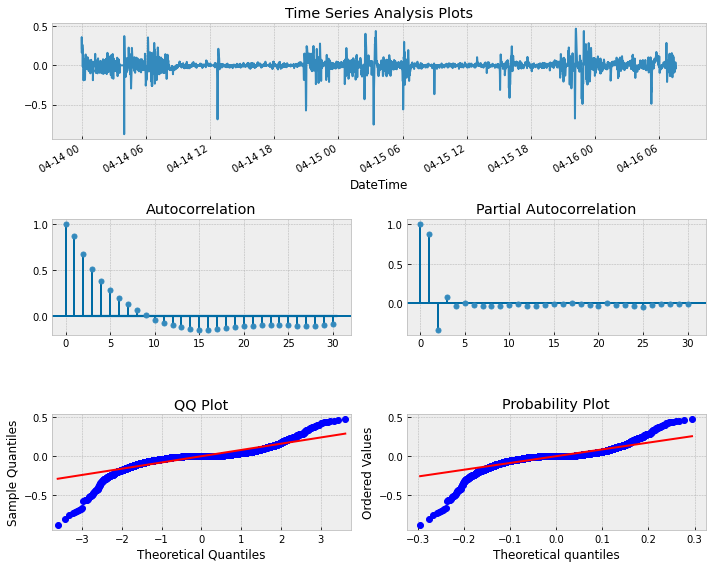

In [17]:
tsplot(df['AirTemp'].resample('30S').mean().diff().dropna(), lags=30)

There seems to be seasonality in the air temperature - will look into this further.

### 3c. CurrentDirection

/Users/ella.franks/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


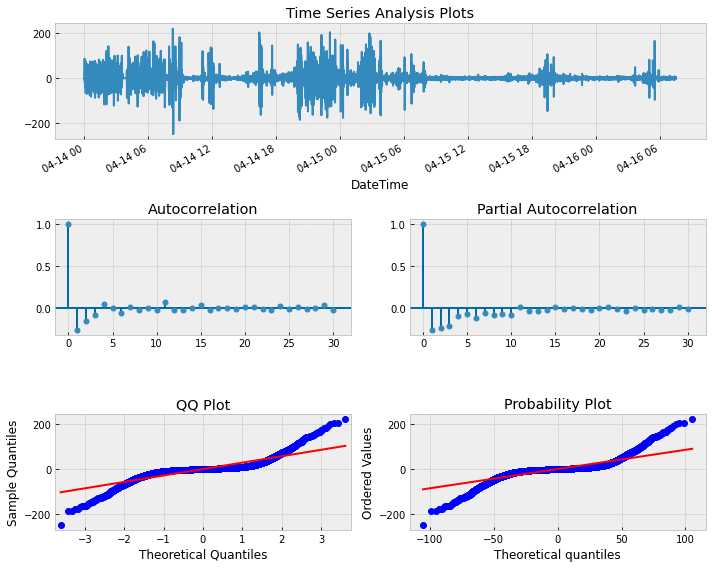

In [20]:
tsplot(df['CurrentDir'].resample('30S').mean().diff().dropna(), lags=30)

In [199]:
# plt.rcParams['figure.figsize']=(15,10)
# plot_pacf(df['Leeway'].resample('30S').mean().diff().dropna(),lags=30)
# plt.show()

---

Even after differencing, the shape of the QQ and Probability plots indicates for all 3 variables, the process is close to normality but with 'heavy tails'. There also appears to be some significant serial correlation in the ACF, and PACF plots around lags 1-6. This means that there should be better models to describe the tacking process.

---

## 4. ARIMA modelling

Since we have made the series stationary, we now satisfy both the assumptions needed to implement ARIMA:
- univariate 
- stanionarity

In [135]:
def make_temp_data(col, time):

    temp_df = df[col].resample(time).mean().dropna()

    train, test = temp_df[0:round(temp_df.shape[0]*0.80)], temp_df[round(temp_df.shape[0]*0.80):]
    return train, test


### 4a. CurrentSpeed modelling: 

Based on the parameters we deduced from the plots above. Our first model specification is ARIMA(3,1,3).

In [202]:
train, test = make_temp_data('CurrentSpeed', '30S')

In [207]:
model = ARIMA(train, order=(3,1,3))
results = model.fit()

In [208]:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.CurrentSpeed   No. Observations:                 5329
Model:                 ARIMA(3, 1, 3)   Log Likelihood                2359.258
Method:                       css-mle   S.D. of innovations              0.155
Date:                Mon, 03 May 2021   AIC                          -4702.516
Time:                        10:33:47   BIC                          -4649.869
Sample:                             1   HQIC                         -4684.124
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0001      0.001      0.160      0.873      -0.002       0.002
ar.L1.D.CurrentSpeed     0.6024      0.231      2.605      0.009       0.149       1.056
ar.L2.D.Curr

Looks like the second lags for both AR and MA components of ARIMA are not statistically sig. 

In [210]:
model = ARIMA(train, order=(2,1,2))
results = model.fit()

In [211]:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.CurrentSpeed   No. Observations:                 5329
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2349.381
Method:                       css-mle   S.D. of innovations              0.156
Date:                Mon, 03 May 2021   AIC                          -4686.761
Time:                        10:34:17   BIC                          -4647.276
Sample:                             1   HQIC                         -4672.967
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0001      0.001      0.154      0.878      -0.002       0.002
ar.L1.D.CurrentSpeed     0.4292      0.123      3.483      0.000       0.188       0.671
ar.L2.D.Curr

We are still in the model selection phase, so we need to use the selection criteria we learned about to compare these two models.

We can observe that in this second specification, all the p-values associated to the different lags (see P>|z| column) are < 0.05, and therefore statistically significant. However, the AIC criterion is -4686 on the second model, which is larger than -4702 on the first model. Given this is such a small difference between the AIC I am going to go with the second model - ARIMA(2,1,2).

In [165]:
# residuals = pd.DataFrame(results.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='%killbgscriptsde', title='Density', ax=ax[1])
# plt.show()

In general, we want the residuals to look like white noise: have a mean of 0, and roughly constant variance. If that were not the case, it means that there is some remaining variability in the data that we are not capturing properly. Attempted Garch model that is good at picking up increased variance, however, AIC was higher and did not peform as well. 

It is also a good idea to look at the distribution of residuals and see if they are symmetric around the mean, and centered around 0. This does seem to be the case here

Now that we have found the best model, let's produce some in-sample forecasts to compare our model predictions to the test data. It is a good idea to produce confidence intervals as well, which give us an idea of how much uncertainty is associated with our predictions.

The wider the confidence intervals, the less likely predictions are to be accurate, or in other words, the more uncertainty is associated to them.

In [212]:
def print_forcast(r, test, n, variable):

    fc, se, conf = r.forecast(n, alpha=0.05)

    fc_series = pd.Series(fc, index=test.index[:n])
    lower_series = pd.Series(conf[:, 0], index=test.index[:n])
    upper_series = pd.Series(conf[:, 1], index=test.index[:n])

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[-20:], label='training')
    plt.plot(test[:n], label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals of {}'.format(variable))
    plt.legend(loc='upper left', fontsize=8)
    return fc_series
    plt.show()

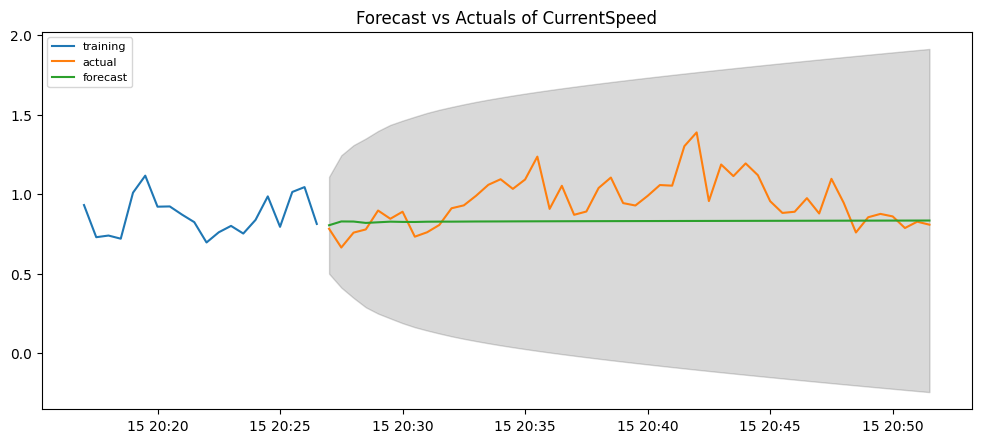

In [206]:
cs_forcast = print_forcast(results, test, 50, 'CurrentSpeed')

In order to evaluate this forecast I will need to compare the list of forecasts to the actual data to assess how close the two are.

In [241]:
def evaluate_accuracy(forecast, actual, n):
    actual = actual[:n]
    fc_act = [forecast.iloc[i]-actual.iloc[i] for i in range(len(actual))]
    mape = np.mean(np.abs(fc_act)/np.abs(actual))  
    rmse = np.mean(np.power(fc_act,2))**.5 
    return({'mape':mape,
             'rmse':rmse})

In [242]:
evaluate_accuracy(cs_forcast,test, 50)

{'mape': 0.14401356536003174, 'rmse': 0.19639902458876904}

Will look to improve this in the future.

---

### 4b. AirTemp modelling: 
Based on the parameters we deduced from the plots above. Our first model specification is ARIMA(3,2,5).

In [250]:
train, test = make_temp_data('AirTemp', '30S')

model = ARIMA(train, order=(3,2,5))
results = model.fit()

In [249]:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:             D2.AirTemp   No. Observations:                 5328
Model:                 ARIMA(3, 2, 5)   Log Likelihood                9947.805
Method:                       css-mle   S.D. of innovations              0.037
Date:                Mon, 03 May 2021   AIC                         -19875.609
Time:                        10:45:15   BIC                         -19809.802
Sample:                             2   HQIC                        -19852.619
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.652e-07   1.89e-06     -0.193      0.847   -4.07e-06    3.34e-06
ar.L1.D2.AirTemp    -0.2064        nan        nan        nan         nan         nan
ar.L2.D2.AirTemp     0.7642 

/Users/ella.franks/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [170]:
# residuals = pd.DataFrame(results.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

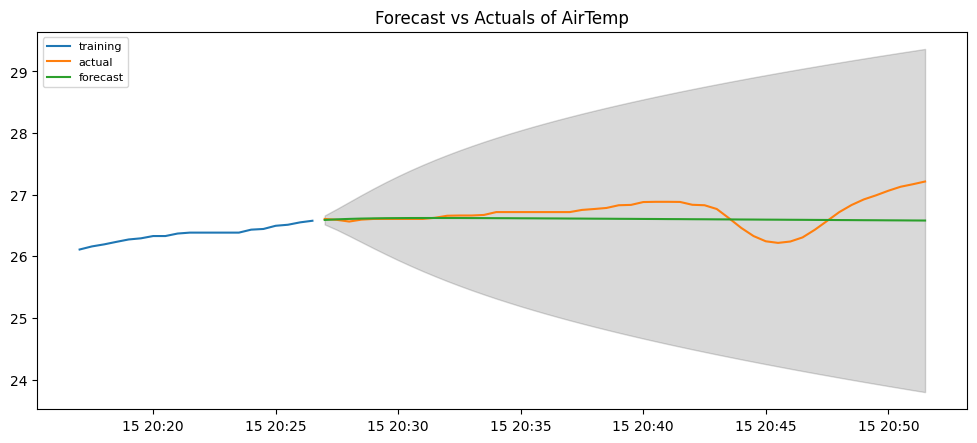

In [172]:
airtemp_forcast = print_forcast(results, test, 50, 'AirTemp')

In [251]:
evaluate_accuracy(airtemp_forcast,test, 50)

{'mape': 0.006740624467133852, 'rmse': 0.24166259113145847}

### 4c. CurrentDirection modelling: 


Based on the parameters we deduced from the plots above. Our first model specification is ARIMA(3,1,6).

In [253]:
train, test = make_temp_data('CurrentDir', '30S')

model = ARIMA(train, order=(3,1,6))
results = model.fit()

In [254]:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.CurrentDir   No. Observations:                 5329
Model:                 ARIMA(3, 1, 6)   Log Likelihood              -25350.748
Method:                       css-mle   S.D. of innovations             28.166
Date:                Mon, 03 May 2021   AIC                          50723.496
Time:                        10:46:24   BIC                          50795.886
Sample:                             1   HQIC                         50748.786
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0139      0.098     -0.142      0.887      -0.206       0.178
ar.L1.D.CurrentDir    -0.3734      0.167     -2.239      0.025      -0.700      -0.047
ar.L2.D.CurrentDir  

In [174]:
# residuals = pd.DataFrame(results.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

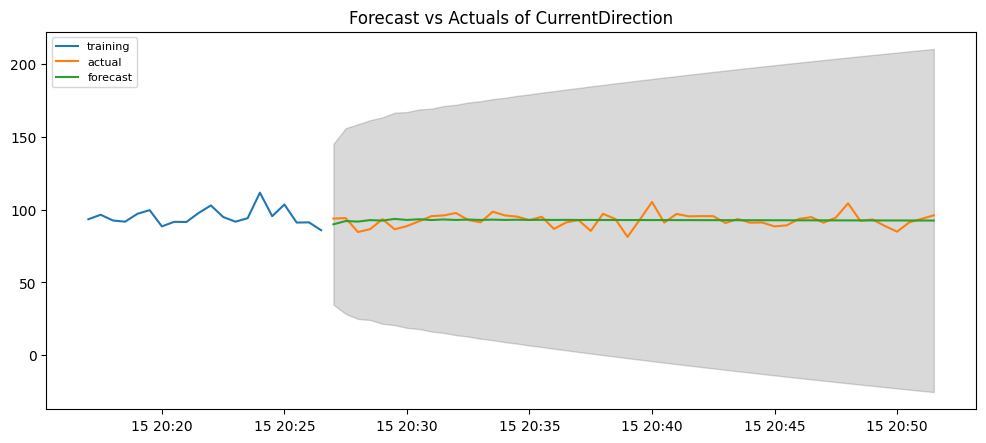

In [176]:
currentdir_forcast = print_forcast(results, test, 50, 'CurrentDirection')

In [255]:
evaluate_accuracy(currentdir_forcast,test, 50)

{'mape': 0.036378048824381795, 'rmse': 4.4640598091816965}

##  5. Using our forecasted predictions in our classification model

Can we predict tacking using all 3 of our weather forcast predictions?

In [148]:
with open('models/rf_model_weather_top3', 'rb') as file:  
    rf = pickle.load(file)

In [149]:
predictions = pd.concat([cs_forcast, airtemp_forcast, currentdir_forcast], 
                      axis=1)
predictions.columns = ['cs_forcast', 'airtemp_forcast', 'cd_forcast']

In [152]:
full_data = pd.concat([predictions, df.resample('30S').mean().dropna()['Tacking']], axis=1, join='inner')
y = full_data.pop('Tacking')

In [157]:
#ONLY no tacking in the data 
y.value_counts()

0.0    50
Name: Tacking, dtype: int64

In [155]:
scaler = StandardScaler()
full_data = pd.DataFrame(scaler.fit_transform(full_data), columns = full_data.columns, index=full_data.index)

In [156]:
rf.score(full_data, y)

0.88

Able to classify with 88 percent tacking using the forecasted values from our ARIMA modelling. Limitations include no instances of tacking in the sample. Would look to have a more diverse sample in the future and improve the forecast, reducing the RMSE.

---